In [1]:
import os
import sys
import glob
import time
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import unicodedata
import string
import copy

In [2]:
writer = SummaryWriter("runs/word-classification")

## 1. Load data

Download and extract the data zip file from [this link](https://download.pytorch.org/tutorial/data.zip). All the .txt files in the names folder can be used to train this word classification model. I have placed those text files in `data/language-words` directory.

In [3]:
data_folder = os.path.join("data", "language-words")
file_paths = glob.glob(os.path.join(data_folder, "*.txt"))
print(file_paths)

['data/language-words/Arabic.txt', 'data/language-words/Chinese.txt', 'data/language-words/Czech.txt', 'data/language-words/Dutch.txt', 'data/language-words/English.txt', 'data/language-words/French.txt', 'data/language-words/German.txt', 'data/language-words/Greek.txt', 'data/language-words/Irish.txt', 'data/language-words/Italian.txt', 'data/language-words/Japanese.txt', 'data/language-words/Korean.txt', 'data/language-words/Polish.txt', 'data/language-words/Portuguese.txt', 'data/language-words/Russian.txt', 'data/language-words/Scottish.txt', 'data/language-words/Spanish.txt', 'data/language-words/Vietnamese.txt']


In [4]:
words_dict = {}
for file_path in file_paths:
    language = file_path.split("/")[2][:-4]
    with open(file_path, "r") as file:
        words = file.readlines()
        words = [word.strip().lower() for word in words]
        words_dict[language] = words
print(words_dict['German'][-10:])

['wolter', 'wörner', 'wörnhör', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']


In [5]:
for language, words in words_dict.items():
    print(language, len(words))

Arabic 2000
Chinese 268
Czech 519
Dutch 297
English 3668
French 277
German 724
Greek 203
Irish 232
Italian 709
Japanese 991
Korean 94
Polish 139
Portuguese 74
Russian 9408
Scottish 100
Spanish 298
Vietnamese 73


## 2. Clean text

In [6]:
characters = set()
for language, words in words_dict.items():
    for word in words:
        characters.update(list(word))
characters = sorted(list(characters))
print(characters)

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ñ', 'ò', 'ó', 'õ', 'ö', 'ù', 'ú', 'ü', 'ą', 'ł', 'ń', 'ś', 'ż']


There are many accented characers in the dataset which have to transformed into the raw format.

In [7]:
c = list('ñ')
c_normalised = list(unicodedata.normalize("NFD", 'ñ'))
print(c, c_normalised)

['ñ'] ['n', '̃']


In [8]:
characters_normalised = []
for character in characters:
    character_normalised = unicodedata.normalize("NFD", character)[0]
    characters_normalised.append(character_normalised)
print(characters_normalised)

[' ', "'", ',', '-', '/', '1', ':', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\xa0', 'ß', 'a', 'a', 'a', 'a', 'c', 'e', 'e', 'e', 'i', 'i', 'n', 'o', 'o', 'o', 'o', 'u', 'u', 'u', 'a', 'ł', 'n', 's', 'z']


In [9]:
characters_all = list(string.ascii_lowercase + " -',:;")
print(len(characters_all), characters_all)

32 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '-', "'", ',', ':', ';']


In [10]:
def clean_word(word):
    cleaned_word = ""
    for character in word:
        for character_raw in unicodedata.normalize('NFD', character):
            if character_raw in characters_all:
                cleaned_word += character_raw
    return cleaned_word

In [11]:
words_dict_cleaned = {}
for language, words in words_dict.items():
    cleaned_words = []
    for word in words:
        cleaned_word = clean_word(word)
        cleaned_words.append(cleaned_word)
    words_dict_cleaned[language] = cleaned_words

In [12]:
print(words_dict['German'][-10:])
print(words_dict_cleaned['German'][-10:])
print(words_dict['Portuguese'][-10:])
print(words_dict_cleaned['Portuguese'][-10:])
print(words_dict['Polish'][-10:])
print(words_dict_cleaned['Polish'][-10:])

['wolter', 'wörner', 'wörnhör', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']
['wolter', 'worner', 'wornhor', 'wruck', 'wyman', 'xylander', 'zellweger', 'zilberschlag', 'zimmerman', 'zimmermann']
['santos', 'serafim', 'silva', 'silveira', 'simões', 'soares', 'souza', 'torres', 'vargas', 'ventura']
['santos', 'serafim', 'silva', 'silveira', 'simoes', 'soares', 'souza', 'torres', 'vargas', 'ventura']
['wyrick', 'wyrzyk', 'zabek', 'zawisza', 'zdunowski', 'zdunowski', 'zielinski', 'ziemniak', 'zientek', 'żuraw']
['wyrick', 'wyrzyk', 'zabek', 'zawisza', 'zdunowski', 'zdunowski', 'zielinski', 'ziemniak', 'zientek', 'zuraw']


In [13]:
words_dict = copy.deepcopy(words_dict_cleaned)
del words_dict_cleaned

## 3. Define utilities

In [14]:
num_langs = len(words_dict.keys())
num_chars = len(characters_all)
print(num_langs, num_chars)

18 32


In [15]:
max_timesteps = 0
for language, words in words_dict.items():
    for word in words:
        if len(word) > max_timesteps:
            max_timesteps = len(word)
print(max_timesteps)

20


In [16]:
lang_to_id = {k:v for k, v in zip(sorted(list(words_dict.keys())), range(len(words_dict.keys())))}
print(lang_to_id)

{'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Polish': 12, 'Portuguese': 13, 'Russian': 14, 'Scottish': 15, 'Spanish': 16, 'Vietnamese': 17}


In [17]:
id_to_lang = {v:k for k, v in lang_to_id.items()}
print(id_to_lang)

{0: 'Arabic', 1: 'Chinese', 2: 'Czech', 3: 'Dutch', 4: 'English', 5: 'French', 6: 'German', 7: 'Greek', 8: 'Irish', 9: 'Italian', 10: 'Japanese', 11: 'Korean', 12: 'Polish', 13: 'Portuguese', 14: 'Russian', 15: 'Scottish', 16: 'Spanish', 17: 'Vietnamese'}


In [18]:
char_to_id = {k:v for k, v in zip(characters_all, range(len(characters_all)))}
print(char_to_id)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, ' ': 26, '-': 27, "'": 28, ',': 29, ':': 30, ';': 31}


In [19]:
id_to_char = {v:k for k, v in char_to_id.items()}
print(id_to_char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: ' ', 27: '-', 28: "'", 29: ',', 30: ':', 31: ';'}


## 4. Split data

In [20]:
words_df = []
for language, words in tqdm(words_dict.items()):
    for word in words:
        words_df.append({"word":word, "language":language})
words_df = pd.DataFrame(words_df)
print(words_df.shape)
words_df.head()


(20074, 2)


,word,language
0,khoury,Arabic
1,nahas,Arabic
2,daher,Arabic
3,gerges,Arabic
4,nazari,Arabic


In [21]:
words_df_train, words_df_dev_test = train_test_split(words_df, train_size=0.8, stratify=words_df["language"], random_state=0)
words_df_dev, words_df_test = train_test_split(words_df_dev_test, train_size=0.5, stratify=words_df_dev_test["language"], random_state=0)
words_df_train = words_df_train.reset_index(drop=True)
words_df_dev = words_df_dev.reset_index(drop=True)
words_df_test = words_df_test.reset_index(drop=True)
print(words_df_train.shape)
print(words_df_dev.shape)
print(words_df_test.shape)

(16059, 2)
(2007, 2)
(2008, 2)


In [22]:
train_count = words_df_train["language"].value_counts().rename("Train")
dev_count = words_df_dev["language"].value_counts().rename("Dev")
test_count = words_df_test["language"].value_counts().rename("Test")
count = pd.concat([train_count, dev_count, test_count], axis=1, sort=True).T
count.loc["Total", :] = count.sum(axis=0) # add row
count.loc[:, "Total"] = count.sum(axis=1) # add col
count = count.astype("int")
count

,Arabic,Chinese,Czech,Dutch,English,French,German,Greek,Irish,Italian,Japanese,Korean,Polish,Portuguese,Russian,Scottish,Spanish,Vietnamese,Total
Train,1600,214,415,238,2934,222,579,163,186,567,793,75,111,59,7526,80,238,59,16059
Dev,200,27,52,29,367,27,72,20,23,71,99,10,14,8,941,10,30,7,2007
Test,200,27,52,30,367,28,73,20,23,71,99,9,14,7,941,10,30,7,2008
Total,2000,268,519,297,3668,277,724,203,232,709,991,94,139,74,9408,100,298,73,20074


## 5. Define dataset

Our PyTorch RNN based model will take input of `Size([mini_batch_size, timesteps, input_size])` and produce output of `Size([mini_batch_size, output_size])`. In order to make uniform timesteps across different words, let us pad with space.

In [23]:
class WordDataset(Dataset):
    
    def __init__(self, words_df):
        self.words_df = words_df
    
    def __len__(self):
        self.len = len(self.words_df)
        return self.len
    
    def __getitem__(self, idx):
        row = self.words_df.iloc[idx, :]
        
        word = row['word'].ljust(max_timesteps)
        x = torch.zeros((max_timesteps, num_chars)) # [timesteps, input_size]
        for i, char in enumerate(word):
            x[i, char_to_id[char]] = 1
        
        # y = np.zeros(num_langs) # [output_size]
        # y[lang_to_id[row['language']]] = 1
        y = lang_to_id[row['language']]
        
        return x, y  

In [24]:
train_set = WordDataset(words_df_train)
dev_set = WordDataset(words_df_dev)
test_set = WordDataset(words_df_test)

## 6. Define dataloader

In [25]:
num_cpus = os.cpu_count()
print(num_cpus)

4


In [26]:
train_batch_size = 4
dev_batch_size = 4
test_batch_size = 4

In [27]:
train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True, num_workers=num_cpus)
dev_loader = DataLoader(dev_set, batch_size=dev_batch_size, shuffle=False, num_workers=num_cpus)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=num_cpus)

In [28]:
train_iter = iter(train_loader)
X, Y = train_iter.next()
print(X.size(), Y.size())

torch.Size([4, 20, 32]) torch.Size([4])


## 7. Define model

In [29]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cpu


In [30]:
class Model(nn.Module):
    
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size)
        
    def forward(self, X):
        batch_size = X.size(0)
        h0 = torch.randn((self.num_layers, batch_size, self.hidden_size))
        c0 = torch.randn((self.num_layers, batch_size, self.hidden_size))
        out, ht = self.lstm1(X, (h0, c0)) # out -> [batch_size, time_steps, input_size]
        outn = out[:,-1,:]
        outn = outn.contiguous().view(batch_size, self.hidden_size)
        outn = self.fc2(outn)
        return outn

In [31]:
model = Model(input_size=num_chars, output_size=num_langs, hidden_size=30, num_layers=1)
model = nn.DataParallel(model)
model = model.to(device)
print(model)

DataParallel(
  (module): Model(
    (lstm1): LSTM(32, 30, batch_first=True)
    (fc2): Linear(in_features=30, out_features=18, bias=True)
  )
)


In [32]:
#list(model.parameters())
for p in model.parameters():
    print(p.dtype)

torch.float32
torch.float32
torch.float32
torch.float32
torch.float32
torch.float32


In [33]:
#summary(model, input_size=(max_timesteps, num_chars))

In [34]:
#writer.add_graph(model, X)
#writer.close()

## 8. Set optimizer

In [35]:
lr = 0.0001
step_size = 100
gamma = 1

In [36]:
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

## 9. Train model

In [37]:
epochs = 50
print_every_n_epochs = 1

In [38]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1)):
    epoch_loss = 0
    epoch_lr = 0
    
    for X, Y in tqdm(train_loader, desc="Epoch-{}".format(epoch)):
        X, Y = X.to(device), Y.to(device)
        
        optimizer.zero_grad()
        Y_pred_logits = model(X)
        loss = criterion(Y_pred_logits, Y)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]
        
    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)


Epoch:1    Loss:1.9324025064001642    LR:9.999999999999305e-05



Epoch:2    Loss:1.7817140070691353    LR:9.999999999999305e-05



Epoch:3    Loss:1.5759836407501255    LR:9.999999999999305e-05



Epoch:4    Loss:1.5209829374618948    LR:9.999999999999305e-05



Epoch:5    Loss:1.4931864589387795    LR:9.999999999999305e-05



Epoch:6    Loss:1.478227173702636    LR:9.999999999999305e-05



Epoch:7    Loss:1.4662800157296554    LR:9.999999999999305e-05



Epoch:8    Loss:1.4531459842113823    LR:9.999999999999305e-05



Epoch:9    Loss:1.4391599032271696    LR:9.999999999999305e-05



Epoch:10    Loss:1.4102269269535284    LR:9.999999999999305e-05



Epoch:11    Loss:1.3587593055806897    LR:9.999999999999305e-05



Epoch:12    Loss:1.3212845224692285    LR:9.999999999999305e-05



Epoch:13    Loss:1.2903549570010355    LR:9.999999999999305e-05



Epoch:14    Loss:1.2645287299769956    LR:9.999999999999305e-05



Epoch:15    Loss:1.2457093703898034    LR:9.999999999999305e-05



Epoch:16    Loss:1.2267724900971517    LR:9.999999999999305e-05



Epoch:17    Loss:1.2133264233259622    LR:9.999999999999305e-05



Epoch:18    Loss:1.1992516421871828    LR:9.999999999999305e-05



Epoch:19    Loss:1.1799309500798139    LR:9.999999999999305e-05



Epoch:20    Loss:1.165987652197601    LR:9.999999999999305e-05



Epoch:21    Loss:1.1524695741253932    LR:9.999999999999305e-05



Epoch:22    Loss:1.1438526454781777    LR:9.999999999999305e-05



Epoch:23    Loss:1.1303476342205352    LR:9.999999999999305e-05



Epoch:24    Loss:1.1194328154974234    LR:9.999999999999305e-05



Epoch:25    Loss:1.1119241759591594    LR:9.999999999999305e-05



Epoch:26    Loss:1.1025051296446218    LR:9.999999999999305e-05



Epoch:27    Loss:1.098806623685154    LR:9.999999999999305e-05



Epoch:28    Loss:1.0926364183541883    LR:9.999999999999305e-05



Epoch:29    Loss:1.0854834143283452    LR:9.999999999999305e-05



Epoch:30    Loss:1.0771248580470385    LR:9.999999999999305e-05



Epoch:31    Loss:1.0705694123687384    LR:9.999999999999305e-05



Epoch:32    Loss:1.0563160145516097    LR:9.999999999999305e-05



Epoch:33    Loss:1.0520367317307615    LR:9.999999999999305e-05



Epoch:34    Loss:1.045143475531743    LR:9.999999999999305e-05



Epoch:35    Loss:1.0366200540683337    LR:9.999999999999305e-05



Epoch:36    Loss:1.026822427636335    LR:9.999999999999305e-05



Epoch:37    Loss:1.0267526941445853    LR:9.999999999999305e-05



Epoch:38    Loss:1.0167326049107923    LR:9.999999999999305e-05



Epoch:39    Loss:1.0084786801197674    LR:9.999999999999305e-05



Epoch:40    Loss:1.0073045699660008    LR:9.999999999999305e-05



Epoch:41    Loss:0.9952171936694992    LR:9.999999999999305e-05



Epoch:42    Loss:0.9887144864411563    LR:9.999999999999305e-05



Epoch:43    Loss:0.9809661529810954    LR:9.999999999999305e-05



Epoch:44    Loss:0.9742935079093071    LR:9.999999999999305e-05



Epoch:45    Loss:0.9666035409571411    LR:9.999999999999305e-05



Epoch:46    Loss:0.9629511730261796    LR:9.999999999999305e-05



Epoch:47    Loss:0.9537010275865505    LR:9.999999999999305e-05



Epoch:48    Loss:0.9486943273941939    LR:9.999999999999305e-05



Epoch:49    Loss:0.9455077301708524    LR:9.999999999999305e-05



Epoch:50    Loss:0.9423192811657815    LR:9.999999999999305e-05



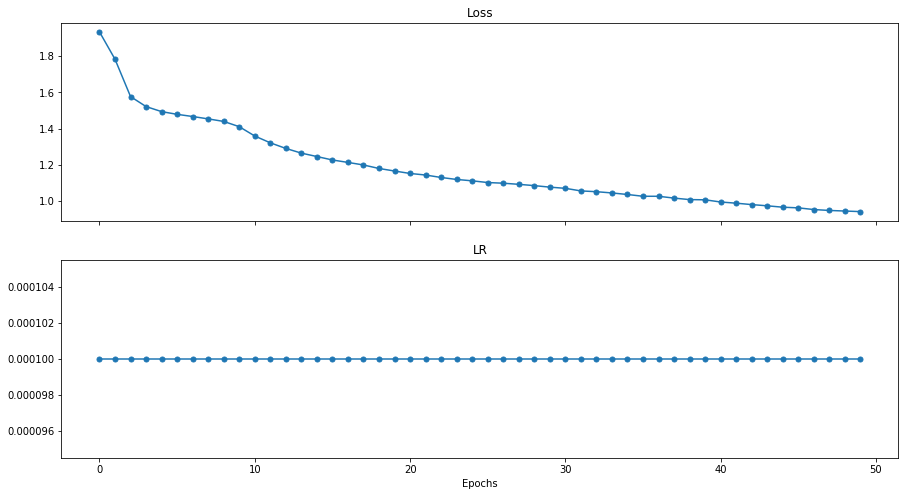

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(epoch_losses, marker="o", markersize=5)
ax1.set_title("Loss")
ax2.plot(epoch_lrs, marker="o", markersize=5)
ax2.set_title("LR")
plt.xlabel("Epochs")
plt.show()

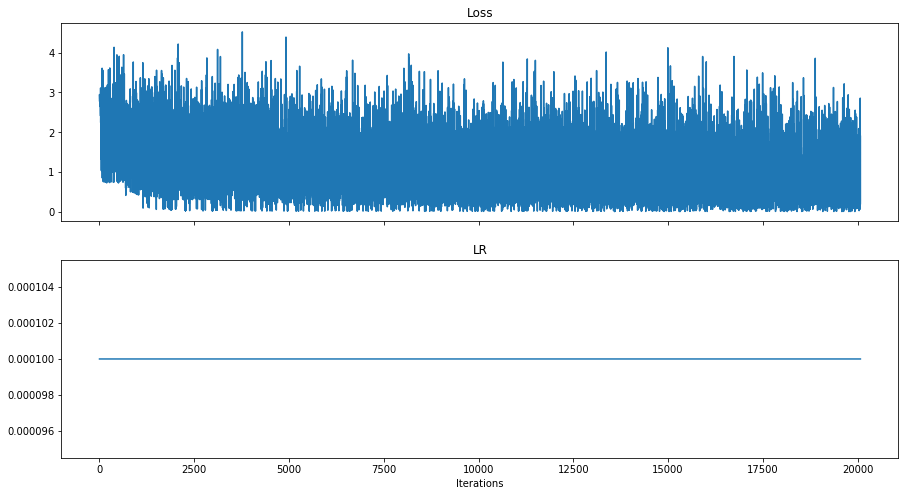

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax1.plot(iteration_losses[::10])
ax1.set_title("Loss")
ax2.plot(iteration_lrs[::10])
ax2.set_title("LR")
plt.xlabel("Iterations")
plt.show()

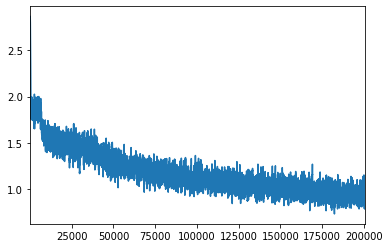

In [41]:
window = 100
pd.Series(iteration_losses).rolling(window=window).mean().iloc[window-1:].plot()
plt.show()

## 10. Test Model

In [42]:
with torch.no_grad():
    Y_train, Y_pred_train = [], []
    for X_mb, Y_mb in tqdm(train_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_train.extend(Y_mb.numpy().tolist())
        Y_pred_train.extend(Y_pred_mb.numpy().tolist())

In [43]:
with torch.no_grad():
    Y_dev, Y_pred_dev = [], []
    for X_mb, Y_mb in tqdm(dev_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_dev.extend(Y_mb.numpy().tolist())
        Y_pred_dev.extend(Y_pred_mb.numpy().tolist())

In [44]:
with torch.no_grad():
    Y_test, Y_pred_test = [], []
    for X_mb, Y_mb in tqdm(test_loader):
        out = model(X_mb)
        _, Y_pred_mb = torch.max(out, 1)
        Y_test.extend(Y_mb.numpy().tolist())
        Y_pred_test.extend(Y_pred_mb.numpy().tolist())

In [45]:
train_accuracy = accuracy_score(Y_train, Y_pred_train)
dev_accuracy = accuracy_score(Y_dev, Y_pred_dev)
test_accuracy = accuracy_score(Y_test, Y_pred_test)
print("Train Accuracy: {}".format(train_accuracy))
print("Dev Accuracy: {}".format(dev_accuracy))
print("Test Accuracy: {}".format(test_accuracy))

Train Accuracy: 0.7261971480166884
Dev Accuracy: 0.7015445939212755
Test Accuracy: 0.7151394422310757


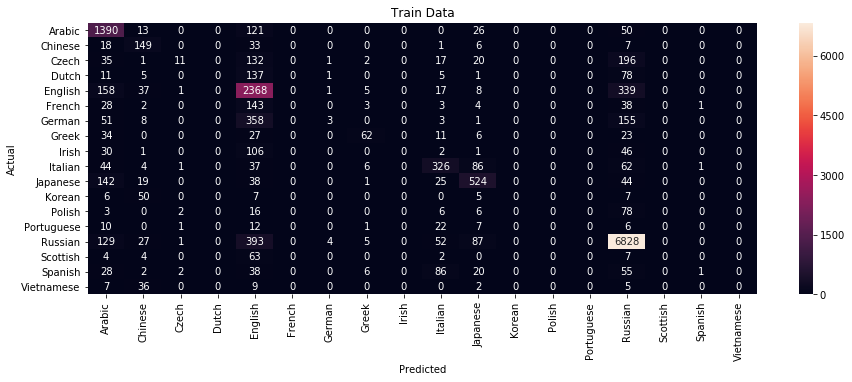

In [46]:
labels = sorted(list(lang_to_id.keys()))
c_mat_train = confusion_matrix(Y_train, Y_pred_train)
plt.figure(figsize=(15,5))
sns.heatmap(c_mat_train, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

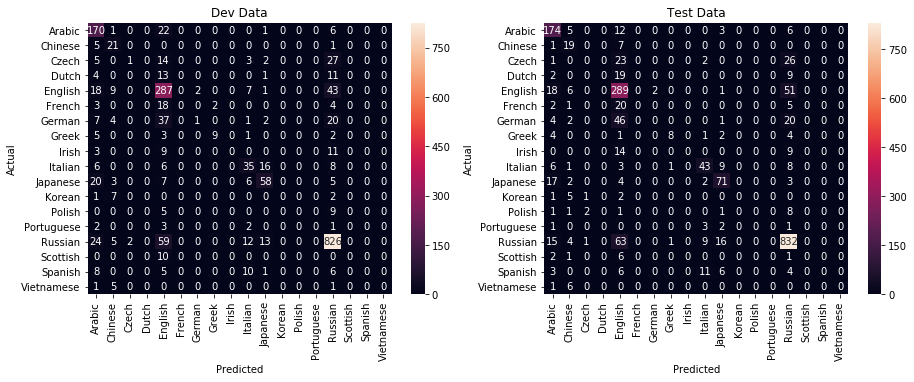

In [47]:
c_mat_dev = confusion_matrix(Y_dev, Y_pred_dev)
c_mat_test = confusion_matrix(Y_test, Y_pred_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(c_mat_dev, annot=True, fmt='d', ax=ax1, xticklabels=labels, yticklabels=labels)
ax1.set_title('Dev Data')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
sns.heatmap(c_mat_test, annot=True, fmt='d', ax=ax2, xticklabels=labels, yticklabels=labels)
ax2.set_title('Test Data')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
plt.show()

In [48]:
def compute_accuracies(c_mat):
    accuracies = c_mat.astype('float') / c_mat.sum(axis=1)
    accuracies = accuracies.diagonal()
    accuracies = {k:v for k, v in zip(labels, accuracies)}
    return accuracies

In [49]:
compute_accuracies(c_mat_train)

{'Arabic': 0.86875,
 'Chinese': 0.6962616822429907,
 'Czech': 0.02650602409638554,
 'Dutch': 0.0,
 'English': 0.8070892978868439,
 'French': 0.0,
 'German': 0.0051813471502590676,
 'Greek': 0.3803680981595092,
 'Irish': 0.0,
 'Italian': 0.5749559082892416,
 'Japanese': 0.6607818411097099,
 'Korean': 0.0,
 'Polish': 0.0,
 'Portuguese': 0.0,
 'Russian': 0.90725484985384,
 'Scottish': 0.0,
 'Spanish': 0.004201680672268907,
 'Vietnamese': 0.0}

In [50]:
compute_accuracies(c_mat_dev)

{'Arabic': 0.85,
 'Chinese': 0.7777777777777778,
 'Czech': 0.019230769230769232,
 'Dutch': 0.0,
 'English': 0.782016348773842,
 'French': 0.0,
 'German': 0.013888888888888888,
 'Greek': 0.45,
 'Irish': 0.0,
 'Italian': 0.49295774647887325,
 'Japanese': 0.5858585858585859,
 'Korean': 0.0,
 'Polish': 0.0,
 'Portuguese': 0.0,
 'Russian': 0.8777895855472901,
 'Scottish': 0.0,
 'Spanish': 0.0,
 'Vietnamese': 0.0}

In [51]:
compute_accuracies(c_mat_test)

{'Arabic': 0.87,
 'Chinese': 0.7037037037037037,
 'Czech': 0.0,
 'Dutch': 0.0,
 'English': 0.7874659400544959,
 'French': 0.0,
 'German': 0.0,
 'Greek': 0.4,
 'Irish': 0.0,
 'Italian': 0.6056338028169014,
 'Japanese': 0.7171717171717171,
 'Korean': 0.0,
 'Polish': 0.0,
 'Portuguese': 0.0,
 'Russian': 0.8841657810839533,
 'Scottish': 0.0,
 'Spanish': 0.0,
 'Vietnamese': 0.0}